In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [32]:
import warnings
warnings.simplefilter('ignore')

from statistics import mean, stdev
from pprint import pprint
import datetime
import dill
import time
import typing as tp

from tqdm import tqdm

import mlflow

import implicit
from implicit.als import AlternatingLeastSquares
from implicit.cpu import _als
from implicit.nearest_neighbours import TFIDFRecommender

import lightfm
from lightfm import LightFM
from lightfm.evaluation import recall_at_k

import scipy as sp
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split


from rectools import Columns
from rectools.metrics import (
    calc_metrics, Recall, Precision, 
    NDCG, MAP, MeanInvUserFreq, Serendipity
)
from rectools.metrics.ranking import NDCG
from rectools.model_selection import TimeRangeSplitter
import rectools.dataset
from rectools.models import ImplicitItemKNNWrapperModel

# Data Preparation

### Interactions

In [3]:
interactions = pd.read_csv('../data/kion_train/interactions.csv')

interactions.rename(columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight
    },
    inplace=True
)

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [4]:
pd.concat([interactions.head(2), interactions.tail(2)])

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [6]:
interactions_default_values: tp.Dict[str, tp.Any] = {
    Columns.Datetime: interactions[Columns.Datetime].median(),
    "total_dur": interactions["total_dur"].median(),
    Columns.Weight: interactions[Columns.Weight].median(),
}
interactions.fillna(interactions_default_values, inplace=True)

interactions.isnull().sum()

user_id      0
item_id      0
datetime     0
total_dur    0
weight       0
dtype: int64

## users

In [7]:
users = pd.read_csv("../data/kion_train/users.csv")
pd.concat([users.head(3), users.tail(3)])

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


In [9]:
def encode_categorical_col(df: pd.DataFrame, 
                           cat_cols: tp.List) -> pd.DataFrame:
    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        df[col] = cat_col.codes.astype('category')
        
    return df

In [10]:
cat_cols = ["age", "income", "sex", "kids_flg"]
users = encode_categorical_col(users, cat_cols)
pd.concat([users.head(3), users.tail(3)])

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0
840194,251008,-1,-1,-1,0
840195,590706,-1,-1,0,0
840196,166555,5,2,0,0


In [11]:
users.isnull().sum()

user_id     0
age         0
income      0
sex         0
kids_flg    0
dtype: int64

In [12]:
users.describe(include='category')

,age,income,sex,kids_flg
count,840197,840197,840197,840197
unique,7,7,3,2
top,1,2,0,0
freq,233926,471519,425270,587209


## items
- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова 
- `description` - описание

In [13]:
items = pd.read_csv("../data/kion_train/items.csv")
pd.concat([items.head(3), items.tail(3)])

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"
15962,3206,series,Гоша,NaN,2019.0,комедии,Россия,0.0,16.0,NaN,Михаил Миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы...","Гоша, 2019, Россия"


In [14]:
items.isnull().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
dtype: int64

In [15]:
items_cat_cols = [
    "content_type", "for_kids", "studios", "age_rating",
]

items_num_cols = [
    "release_year",
]

items_text_cols = [
    "title", "genres", "countries", "description", "keywords",
]

items_drop_cols = [
    "title_orig", "directors", "actors",
]

default_values_items: tp.Dict[str, tp.Any] = {
    "release_year": items["release_year"].median(),
    "countries": "",
    "description": "",
    "keywords": "",
}


items = encode_categorical_col(items, items_cat_cols) 
items = items.drop(items_drop_cols, axis=1)
items.fillna(default_values_items, inplace=True)

In [16]:
items.isnull().sum()

item_id         0
content_type    0
title           0
release_year    0
genres          0
countries       0
for_kids        0
age_rating      0
studios         0
description     0
keywords        0
dtype: int64

### `release_year` prepare

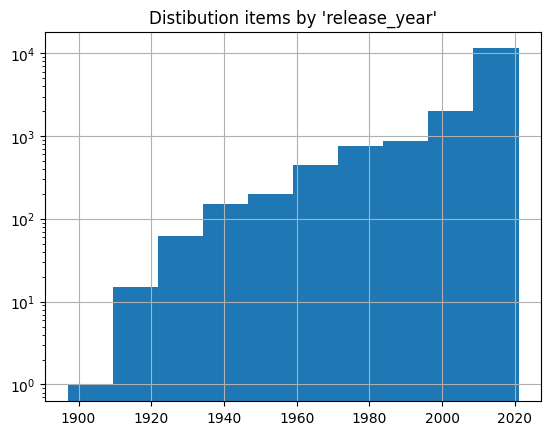

In [17]:
title = "Distibution items by 'release_year'"
items["release_year"].hist(log=True).set_title(title);

In [18]:
_, bins = pd.qcut(items["release_year"], 10, retbins=True)
labels = bins[:-1]

items["release_year"] = pd.cut(items["release_year"], bins=bins, labels=bins[:-1])

In [19]:
items.describe(include='all')

,item_id,content_type,title,release_year,genres,countries,for_kids,age_rating,studios,description,keywords
count,15963.000000,15963.0,15963,15962.0,15963,15963,15963.0,15963.0,15963.0,15963,15963
unique,NaN,2.0,15293,10.0,2771,688,3.0,7.0,39.0,15620,15493
top,NaN,0.0,Охота,2016.0,документальное,Россия,-1.0,3.0,-1.0,МТС «Карантинники» — это домашние акустические...,
freq,NaN,12002.0,5,2327.0,816,4237,15397.0,5729.0,14898.0,36,423
mean,8268.453424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4773.841513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,4141.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,8266.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,12414.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Train-Val-Test Split

In [20]:
min_data = interactions[Columns.Datetime].min()
max_data = interactions[Columns.Datetime].max()

print(f"min data: {min_data}")
print(f"max datal: {max_data}")
print(f"duration {max_data - min_data}")

min data: 2021-03-13 00:00:00
max datal: 2021-08-22 00:00:00
duration 162 days 00:00:00


1. **для модели ранжирования** зафиксируем данные на отрезки **последних 30 дней**
2. разделим данные из **п.1 на train, val, test** в процентном соотношении **70, 15, 15**

In [21]:
RANKER_SPLIT = {
    "ranker_days": 30, 
    "train_size": 0.7,
    "val_size": 0.15,
    "test_size": 0.15,
}

In [22]:
candidate_data_train = interactions[
    interactions[Columns.Datetime] < max_data - pd.Timedelta(days=RANKER_SPLIT["ranker_days"])
]

In [23]:
ranker_data = interactions[
    interactions[Columns.Datetime] >= max_data - pd.Timedelta(days=RANKER_SPLIT["ranker_days"])
]

ranker_train_val_users, ranker_test_users = train_test_split(
    ranker_data["user_id"].unique(), 
    test_size=RANKER_SPLIT["test_size"], 
    random_state=17,
)

ranker_train_users, ranker_val_users = train_test_split(
    ranker_train_val_users, 
    test_size=RANKER_SPLIT["val_size"] / (RANKER_SPLIT["val_size"] + RANKER_SPLIT["train_size"]), 
    random_state=17,
)

In [24]:
min_data_candidate = candidate_data_train[Columns.Datetime].min()
max_data_candidate = candidate_data_train[Columns.Datetime].max()

print(f"min data: {min_data_candidate}")
print(f"max datal: {max_data_candidate}")
print(f"duration {max_data_candidate - min_data_candidate}")

print("======")

min_data_ranker = ranker_data[Columns.Datetime].min()
max_data_ranker = ranker_data[Columns.Datetime].max()

print(f"min data: {min_data_ranker}")
print(f"max datal: {max_data_ranker}")
print(f"duration {max_data_ranker - min_data_ranker}")

min data: 2021-03-13 00:00:00
max datal: 2021-07-22 00:00:00
duration 131 days 00:00:00
min data: 2021-07-23 00:00:00
max datal: 2021-08-22 00:00:00
duration 30 days 00:00:00


In [25]:
print(f"Ranker train users count: {ranker_train_users.shape[0]}")
print(f"Ranker val users count: {ranker_val_users.shape[0]}")
print(f"Ranker test users count: {ranker_test_users.shape[0]}") 

Ranker train users count: 304047
Ranker val users count: 65153
Ranker test users count: 65153


# CV for models first steps

## Split 

**Валидация** для модели 1 этапа **будет по 7 дней**

In [27]:
def create_data_range(last_date: pd.Timestamp,
                      n_folds: int = 7,
                      unit: str = "W",
                      n_units: int = 1,
                      show: bool = True,) -> pd.date_range:
    
    periods = n_folds + 1
    freq = f"{n_units}{unit}"

    start_date = last_date - pd.Timedelta(n_folds * n_units + n_units, unit=unit)

    date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)

    if show:
        print(
            f"start_date: {start_date}\n"
            f"last_date: {last_date}\n"
            f"periods: {periods}\n"
            f"freq: {freq}\n"
            f"Test fold borders: {date_range.values.astype('datetime64[D]')}\n"
        )

    return date_range

In [28]:
CONFIG_CV = {
    "n_folds": 5,
    "unit": "W",
    "n_units": 1,
}

In [29]:
date_range = create_data_range(
    max_data_candidate,
    n_folds=CONFIG_CV["n_folds"],
    unit=CONFIG_CV["unit"],
    n_units=CONFIG_CV["n_units"]
)

start_date: 2021-06-10 00:00:00
last_date: 2021-07-22 00:00:00
periods: 6
freq: 1W
Test fold borders: ['2021-06-13' '2021-06-20' '2021-06-27' '2021-07-04' '2021-07-11'
 '2021-07-18']



In [31]:
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

assert cv.get_n_splits(
    rectools.dataset.Interactions(candidate_data_train)) == CONFIG_CV["n_folds"], "Number of folds not equal"

### metrics

In [35]:
metrics = {
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),  # Main metrices for candidates-model 
    "MAP@10": MAP(k=10),
    "NDCG@10": NDCG(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

### Models

Т.к. на предыдуших этапах разработки **лучшей моделью была TFIDFRecommender(k=60)** с результатом на лидерборд по метрике **MAP@10 = 0.0957743**, то её также стоит попробовать в качестве модели для генерации кандидатов.

Также не стоит забывать, что для этапа **генерации кандидатов**, важной метрикой является **Recall@k**, т.к. работа дальше будет вестись с ними и по логике **ранкеру** нужно **отдать наиболее полный список кандиатов**

**Модели**, среди которых будет происходить отбор: 
1. TFIDFRecommender(k=60)
2. iALS
3. LightFM

In [41]:
TRACKING_URI = "http://localhost:5555/"
NAME_EXPERIMENT = "First-Level-Model"

mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(NAME_EXPERIMENT)

2023/04/15 17:44:39 INFO mlflow.tracking.fluent: Experiment with name 'First-Level-Model' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow/4', creation_time=1681569879321, experiment_id='4', last_update_time=1681569879321, lifecycle_stage='active', name='First-Level-Model', tags={}>

In [42]:
mlflow.get_registry_uri(), mlflow.get_tracking_uri()

('http://localhost:5555/', 'http://localhost:5555/')

In [43]:
K_RECOS = 10  # Number of recommendation for validation

In [187]:
# ===== INV MAPING =====
def inv_mapping_implicit(df: pd.DataFrame) -> tp.Tuple[tp.Dict[int, int]]:
    users_inv_mapping = dict(enumerate(df[Columns.User].unique()))
    users_mapping = {v: k for k, v in users_inv_mapping.items()}
    items_inv_mapping = dict(enumerate(df[Columns.Item].unique()))
    items_mapping = {v: k for k, v in items_inv_mapping.items()}
    
    return (users_inv_mapping, users_mapping, 
            items_inv_mapping, items_mapping)


def inv_mapping_lightfm(lightfm_dataset: lightfm.data.Dataset) -> tp.Tuple[tp.Dict[int, int]]:
    lightfm_mapping = lightfm_dataset.mapping()
    lightfm_mapping = {
        'user_id_to_iid': lightfm_mapping[0],  # iid - internal lfm id
        'item_id_to_iid': lightfm_mapping[2],
    }
    
    lightfm_mapping['user_iid_to_id'] = {v: k for k, v in lightfm_mapping['user_id_to_iid'].items()}
    lightfm_mapping['item_iid_to_id'] = {v: k for k, v in lightfm_mapping['item_id_to_iid'].items()}
    
    return lightfm_mapping


# ===== DATA FOR FIT =====
def create_data_implicit(
    df: pd.DataFrame,
    user_col: str = Columns.User,
    item_col: str = Columns.Item,
    weight_col: str = None,
    users_mapping: tp.Dict[int, int] = None,
    items_mapping: tp.Dict[int, int] = None,
) -> sp.sparse.csr_matrix:

    if weight_col:
        weights = df[weight_col].astype(np.float32)
    else:
        weights = np.ones(len(df), dtype=np.float32)

    interaction_matrix = sp.sparse.coo_matrix((
        weights,
        (
            df[user_col].map(users_mapping.get),
            df[item_col].map(items_mapping.get)
        )
    ))

    return interaction_matrix


def create_data_lightfm(
    df: pd.DataFrame, 
    col_user: str = Columns.User,
    col_item: str = Columns.Item, 
    col_weight: str = None
) -> tp.Tuple:

    lightfm_dataset = lightfm.data.Dataset()
    lightfm_user_ids = df[col_user].unique()
    lightfm_item_ids = df[col_item].unique()
    lightfm_dataset.fit(lightfm_user_ids, lightfm_item_ids)
    
    if col_weight is not None:
        interactions_matrix, weights_matrix = lightfm_dataset.build_interactions(
            zip(*df[[col_user, col_item, col_weight]].values.T)
        )
    else:
        interactions_matrix, weights_matrix = lightfm_dataset.build_interactions(
            zip(*df[[col_user, col_item]].values.T)
        )
        
    weights_matrix = weights_matrix.tocsr()
    interactions_matrix = interactions_matrix.tocsr()
    
    return lightfm_dataset, weights_matrix, interactions_matrix


# ===== MAPPERS FOR RECOMMENDER =====
def generate_implicit_recs_mapper(
    model: implicit, 
    weight_matrix: sp.sparse.csr_matrix, 
    user_mapping: tp.Dict[int, int], 
    item_inv_mapping: tp.Dict[int, int],
    N: int = 10, 
    return_score: bool = False
) -> tp.Callable:
    
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.recommend(user_id, 
                               weight_matrix[user_id], 
                               N=N, 
                               filter_already_liked_items=True)
        if return_score:
            return (
                [item_inv_mapping[item] for item in recs[0]], 
                [score for score in recs[1]]
            )
        
        return [item_inv_mapping[item] for item in recs[0]]
    
    return _recs_mapper


def generate_lightfm_recs_mapper(
    model: LightFM, 
    item_iids: tp.List[int],
    user_id_to_iid: tp.Dict[int, int], 
    item_iid_to_id: tp.Dict[int, int], 
    known_item_ids: tp.Dict[int, tp.Set[int]],
    N: int = 10, 
    user_features:  tp.Optional[sp.sparse.csr_matrix] = None, 
    item_features: tp.Optional[sp.sparse.csr_matrix] = None, 
    num_threads: int = 1,
    return_score: bool=False
) -> tp.Callable:
    def _recs_mapper(user):
        user_id = user_id_to_iid[user]
        scores_vector = model.predict(user_id, item_iids, user_features=user_features,
                                      item_features=item_features, num_threads=num_threads)
       
        additional_N = len(known_item_ids[user_id]) if user_id in known_item_ids else 0
        total_N = N + additional_N
        top_iids = np.argpartition(scores_vector, -np.arange(total_N))[-total_N:][::-1]

        if additional_N > 0:
            filter_items = known_item_ids[user_id]
            top_iids = [item_index for item_index in top_iids if item_iid_to_id[item_index] not in filter_items]

        final_recs = [item_iid_to_id[item_index] for item_index in top_iids]
        if return_score:
            return final_recs, scores_vector[top_iids]
        return final_recs
    return _recs_mapper


# ===== FIT MODELS BY EPOCHS =====
def train_als_by_epochs(
    model: AlternatingLeastSquares, 
    weight_matrix: sp.sparse.csr_matrix,
    n_epochs: int,
    idx_fold: int,
) -> AlternatingLeastSquares:

    for idx_epoch in tqdm(range(n_epochs)):
        model.fit(weight_matrix, show_progress=False)
        curr_user_factors = model.user_factors
        curr_item_factors = model.item_factors

        loss = _als.calculate_loss(weight_matrix, 
                                   curr_user_factors,
                                   curr_item_factors,
                                   model.regularization,
                                   num_threads=model.num_threads,)
        
        mlflow.log_metrics({f"Loss_Fold-{idx_fold}": loss}, step=idx_epoch + 1)
    
    return model


def train_lightfm_by_epochs(
    model: LightFM, 
    weight_matrix: sp.sparse.csr_matrix,
    n_epochs: int,
) -> tp.Dict[AlternatingLeastSquares, tp.List]:

    for _ in tqdm(range(n_epochs)):
        model.fit_partial(weight_matrix)
    
    return model


# ===== Get model size ======
def model_size(model) -> float:
    tmp_file = "tmp_model.dill"
    with open(tmp_file, "wb") as file:
        dill.dump(model, file)
        
    file_stats = os.stat(tmp_file)
    size_in_mb = file_stats.st_size / (1024 * 1024)
    
    os.remove(tmp_file)
    
    return size_in_mb

### ALS

In [94]:
PARAMS_ALS = {
    "n_factors": [32, 64, ],
    "n_epochs": [30, ],
}

In [102]:
for n_factors in PARAMS_ALS["n_factors"]:
    for n_epochs in PARAMS_ALS["n_epochs"]:
        with mlflow.start_run():

            MODEL_NAME = f"ALS_{n_factors}"
            TIMESTAMP = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")

            mlflow.set_tag("mlflow.runName", f"{MODEL_NAME}-{TIMESTAMP}")
            mlflow.log_params({"factors": n_factors, 
                               "epochs": n_epochs,})

            fold_iterator = cv.split(
                rectools.dataset.Interactions(candidate_data_train), 
                collect_fold_stats=True
            )
            for idx_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
                print(f"\n==================== Fold {idx_fold}")
                pprint(fold_info)

                curr_model = AlternatingLeastSquares(factors=n_factors, 
                                                     num_threads=16, 
                                                     iterations=1,
                                                     random_state=17)

                train = candidate_data_train.iloc[train_ids].copy()
                test = candidate_data_train.iloc[test_ids].copy()
                catalog = items[Columns.Item].unique()

                users_inv_mapping, users_mapping, items_inv_mapping, items_mapping = inv_mapping_implicit(train)

                curr_weight_matrix = create_data_implicit(
                    df=train, 
                    users_mapping=users_mapping, 
                    items_mapping=items_mapping,
                ).tocsr()

                # Training by epochs
                start_time_fit = time.monotonic()
                curr_model = train_als_by_epochs(
                    curr_model, 
                    curr_weight_matrix,
                    n_epochs,
                    idx_fold,
                )
                time_fit = time.monotonic() - start_time_fit

                assert curr_model.user_factors.shape[0] == train[Columns.User].nunique(), "Not equal number of users"
                assert curr_model.item_factors.shape[0] == train[Columns.Item].nunique(), "Not equal number of items"

                # Calculate metrics by fold
                curr_mapper = generate_implicit_recs_mapper(
                    curr_model,
                    curr_weight_matrix,
                    users_mapping,
                    items_inv_mapping,
                    K_RECOS,
                    return_score=False
                )

                curr_recs = pd.DataFrame({
                    Columns.User: test[Columns.User].unique()
                })
                curr_recs[Columns.Item] = curr_recs[Columns.User].map(curr_mapper)
                curr_recs = curr_recs.explode(Columns.Item, ignore_index=True)
                curr_recs[Columns.Rank] = curr_recs.groupby(Columns.User).cumcount() + 1

                metrics_values = calc_metrics(
                    metrics,
                    reco=curr_recs,
                    interactions=test,
                    prev_interactions=train,
                    catalog=catalog
                )

                metrics_values = {
                    name_metric.replace("@", "_at_") + "_by_Fold": value
                    for name_metric, value in metrics_values.items()
                }

                metrics_values["time_fit"] =  time_fit

                mlflow.log_metrics(metrics_values, step=idx_fold + 1)

            last_model_size = model_size(curr_model)
            mlflow.log_metric("model_size_MB", last_model_size)



==================== Fold 0
{'End date': Timestamp('2021-06-20 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-13 00:00:00', freq='W-SUN'),
 'Test': 198116,
 'Test items': 5691,
 'Test users': 81827,
 'Train': 1937299,
 'Train items': 13611,
 'Train users': 431674}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:35<00:00,  1.20s/it]



==================== Fold 1
{'End date': Timestamp('2021-06-27 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-20 00:00:00', freq='W-SUN'),
 'Test': 189448,
 'Test items': 5823,
 'Test users': 76307,
 'Train': 2239369,
 'Train items': 13843,
 'Train users': 488871}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:40<00:00,  1.35s/it]



==================== Fold 2
{'End date': Timestamp('2021-07-04 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-27 00:00:00', freq='W-SUN'),
 'Test': 237414,
 'Test items': 5947,
 'Test users': 98930,
 'Train': 2533586,
 'Train items': 14092,
 'Train users': 536802}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:45<00:00,  1.51s/it]



==================== Fold 3
{'End date': Timestamp('2021-07-11 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-07-04 00:00:00', freq='W-SUN'),
 'Test': 211146,
 'Test items': 6209,
 'Test users': 86167,
 'Train': 2886800,
 'Train items': 14357,
 'Train users': 595902}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:51<00:00,  1.71s/it]



==================== Fold 4
{'End date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-07-11 00:00:00', freq='W-SUN'),
 'Test': 214489,
 'Test items': 6313,
 'Test users': 84234,
 'Train': 3192875,
 'Train items': 14711,
 'Train users': 640144}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:56<00:00,  1.88s/it]



==================== Fold 0
{'End date': Timestamp('2021-06-20 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-13 00:00:00', freq='W-SUN'),
 'Test': 198116,
 'Test items': 5691,
 'Test users': 81827,
 'Train': 1937299,
 'Train items': 13611,
 'Train users': 431674}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:57<00:00,  1.93s/it]



==================== Fold 1
{'End date': Timestamp('2021-06-27 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-20 00:00:00', freq='W-SUN'),
 'Test': 189448,
 'Test items': 5823,
 'Test users': 76307,
 'Train': 2239369,
 'Train items': 13843,
 'Train users': 488871}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:06<00:00,  2.20s/it]



==================== Fold 2
{'End date': Timestamp('2021-07-04 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-27 00:00:00', freq='W-SUN'),
 'Test': 237414,
 'Test items': 5947,
 'Test users': 98930,
 'Train': 2533586,
 'Train items': 14092,
 'Train users': 536802}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:13<00:00,  2.47s/it]



==================== Fold 3
{'End date': Timestamp('2021-07-11 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-07-04 00:00:00', freq='W-SUN'),
 'Test': 211146,
 'Test items': 6209,
 'Test users': 86167,
 'Train': 2886800,
 'Train items': 14357,
 'Train users': 595902}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:27<00:00,  2.92s/it]



==================== Fold 4
{'End date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-07-11 00:00:00', freq='W-SUN'),
 'Test': 214489,
 'Test items': 6313,
 'Test users': 84234,
 'Train': 3192875,
 'Train items': 14711,
 'Train users': 640144}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:35<00:00,  3.17s/it]


### LightFM

В библиотеке **LightFM нет** функции возвращающей **Loss** => буду **логировать по фолдам качество модели на заранее определенных метриках**

In [103]:
PARAMS_LFM = {
    "no_components": [32, 64, ],
    "n_epochs": [30, ],
}

In [107]:
for no_components in PARAMS_LFM["no_components"]:
    for n_epochs in PARAMS_LFM["n_epochs"]:
        with mlflow.start_run():
            MODEL_NAME = f"LightFM_{no_components}"
            TIMESTAMP = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")

            mlflow.set_tag("mlflow.runName", f"{MODEL_NAME}-{TIMESTAMP}")
            mlflow.log_params({"no_components": no_components, 
                               "epochs": n_epochs,})

            fold_iterator = cv.split(
                rectools.dataset.Interactions(candidate_data_train), 
                collect_fold_stats=True
            )
            for idx_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
                print(f"\n==================== Fold {idx_fold}")
                pprint(fold_info)

                curr_model = LightFM(no_components=no_components, 
                                     learning_rate=0.1,
                                     loss='warp', 
                                     max_sampled=10, 
                                     random_state=17,)

                train = candidate_data_train.iloc[train_ids].copy()
                test = candidate_data_train.iloc[test_ids].copy()
                catalog = items[Columns.Item].unique()

                curr_lightfm_dataset, curr_weights_matrix, curr_train_interations = create_data_lightfm(train)
                _, _, curr_test_interations = create_data_lightfm(test)

                curr_lightfm_mapping = inv_mapping_lightfm(curr_lightfm_dataset)
                curr_user_lfm_index = np.array(list(curr_lightfm_mapping['user_id_to_iid'].values()))
                curr_item_lfm_index = np.array(list(curr_lightfm_mapping['item_id_to_iid'].values()))

                # Training by epochs
                start_time_fit = time.monotonic()
                curr_model = train_lightfm_by_epochs(
                    curr_model, 
                    curr_weight_matrix,
                    n_epochs,
                )
                time_fit = time.monotonic() - start_time_fit

                # Calculate metrics by fold
                curr_mapper = generate_lightfm_recs_mapper(
                    model=curr_model, 
                    N=K_RECOS,
                    item_iids=curr_item_lfm_index, 
                    user_id_to_iid=curr_lightfm_mapping['user_id_to_iid'],
                    item_iid_to_id=curr_lightfm_mapping['item_iid_to_id'],
                    known_item_ids=train.groupby("user_id")["item_id"].agg(set).to_dict(),
                    num_threads=5,
                )
                
                curr_recs = pd.DataFrame({
                    Columns.User: test[Columns.User].unique()
                })
                curr_recs[Columns.Item] = curr_recs['user_id'].map(curr_mapper)
                curr_recs = curr_recs.explode(Columns.Item, ignore_index=True)
                curr_recs[Columns.Rank] = curr_recs.groupby(Columns.User).cumcount() + 1

                metrics_values = calc_metrics(
                    metrics,
                    reco=curr_recs,
                    interactions=test,
                    prev_interactions=train,
                    catalog=catalog
                )

                metrics_values = {
                    name_metric.replace("@", "_at_") + "_by_Fold": value
                    for name_metric, value in metrics_values.items()
                }

                metrics_values["time_fit"] =  time_fit

                mlflow.log_metrics(metrics_values, step=idx_fold + 1)

            last_model_size = model_size(curr_model)
            mlflow.log_metric("model_size_MB", last_model_size)
            
        print("=============================================")


==================== Fold 0
{'End date': Timestamp('2021-06-20 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-13 00:00:00', freq='W-SUN'),
 'Test': 198116,
 'Test items': 5691,
 'Test users': 81827,
 'Train': 1937299,
 'Train items': 13611,
 'Train users': 431674}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:26<00:00,  2.90s/it]



==================== Fold 1
{'End date': Timestamp('2021-06-27 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-20 00:00:00', freq='W-SUN'),
 'Test': 189448,
 'Test items': 5823,
 'Test users': 76307,
 'Train': 2239369,
 'Train items': 13843,
 'Train users': 488871}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:22<00:00,  2.76s/it]



==================== Fold 2
{'End date': Timestamp('2021-07-04 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-27 00:00:00', freq='W-SUN'),
 'Test': 237414,
 'Test items': 5947,
 'Test users': 98930,
 'Train': 2533586,
 'Train items': 14092,
 'Train users': 536802}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:22<00:00,  2.76s/it]



==================== Fold 3
{'End date': Timestamp('2021-07-11 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-07-04 00:00:00', freq='W-SUN'),
 'Test': 211146,
 'Test items': 6209,
 'Test users': 86167,
 'Train': 2886800,
 'Train items': 14357,
 'Train users': 595902}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:22<00:00,  2.76s/it]



==================== Fold 4
{'End date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-07-11 00:00:00', freq='W-SUN'),
 'Test': 214489,
 'Test items': 6313,
 'Test users': 84234,
 'Train': 3192875,
 'Train items': 14711,
 'Train users': 640144}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:23<00:00,  2.78s/it]



==================== Fold 0
{'End date': Timestamp('2021-06-20 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-13 00:00:00', freq='W-SUN'),
 'Test': 198116,
 'Test items': 5691,
 'Test users': 81827,
 'Train': 1937299,
 'Train items': 13611,
 'Train users': 431674}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:50<00:00,  3.68s/it]



==================== Fold 1
{'End date': Timestamp('2021-06-27 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-20 00:00:00', freq='W-SUN'),
 'Test': 189448,
 'Test items': 5823,
 'Test users': 76307,
 'Train': 2239369,
 'Train items': 13843,
 'Train users': 488871}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:50<00:00,  3.69s/it]



==================== Fold 2
{'End date': Timestamp('2021-07-04 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-06-27 00:00:00', freq='W-SUN'),
 'Test': 237414,
 'Test items': 5947,
 'Test users': 98930,
 'Train': 2533586,
 'Train items': 14092,
 'Train users': 536802}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:49<00:00,  3.66s/it]



==================== Fold 3
{'End date': Timestamp('2021-07-11 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-07-04 00:00:00', freq='W-SUN'),
 'Test': 211146,
 'Test items': 6209,
 'Test users': 86167,
 'Train': 2886800,
 'Train items': 14357,
 'Train users': 595902}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:47<00:00,  3.60s/it]



==================== Fold 4
{'End date': Timestamp('2021-07-18 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-07-11 00:00:00', freq='W-SUN'),
 'Test': 214489,
 'Test items': 6313,
 'Test users': 84234,
 'Train': 3192875,
 'Train items': 14711,
 'Train users': 640144}


100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:48<00:00,  3.60s/it]


# Comparison of results first-level model

In [122]:
from mlflow.client import MlflowClient

In [108]:
current_experiment = dict(mlflow.get_experiment_by_name(NAME_EXPERIMENT))
experiment_id = current_experiment['experiment_id']
experiment_id

'4'

In [114]:
df_mlflow = mlflow.search_runs([experiment_id])
df_mlflow

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.novelty_by_Fold,metrics.serendipity_by_Fold,metrics.model_size_MB,metrics.recall_at_10_by_Fold,...,metrics.Loss_Fold-4,metrics.Loss_Fold-0,params.epochs,params.no_components,params.factors,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.runName
0,4fc20facdc4342bfbac64c9160a82351,4,FINISHED,s3://mlflow/4/4fc20facdc4342bfbac64c9160a82351...,2023-04-15 16:20:27.222000+00:00,2023-04-15 16:39:15.179000+00:00,5.742183,0.000057,487.128104,0.167069,...,NaN,NaN,30,64,None,LOCAL,8d96af5b9382e647e214bfe915ae3c1c108d91c0,/Users/andrewsemenov/PycharmProjects/ITMO/RecS...,andrewsemenov,LightFM_64-04-15-2023-19-20-27
1,43cfc518ea3f448aa79456ec3d99c70b,4,RUNNING,s3://mlflow/4/43cfc518ea3f448aa79456ec3d99c70b...,2023-04-15 16:04:44.186000+00:00,NaT,5.437335,0.000054,247.313042,0.174159,...,NaN,NaN,30,32,None,LOCAL,8d96af5b9382e647e214bfe915ae3c1c108d91c0,/Users/andrewsemenov/PycharmProjects/ITMO/RecS...,andrewsemenov,LightFM_32-04-15-2023-19-04-44
2,aceb45e1fee84e7db05426d074c37dfd,4,FINISHED,s3://mlflow/4/aceb45e1fee84e7db05426d074c37dfd...,2023-04-15 15:50:46.250000+00:00,2023-04-15 15:59:01.819000+00:00,7.288883,0.000080,159.877254,0.058053,...,0.000208,0.000219,30,None,64,LOCAL,8d96af5b9382e647e214bfe915ae3c1c108d91c0,/Users/andrewsemenov/PycharmProjects/ITMO/RecS...,andrewsemenov,ALS_64-04-15-2023-18-50-46
3,29a2218173a54435ad6c363cf2a2c7e7,4,FINISHED,s3://mlflow/4/29a2218173a54435ad6c363cf2a2c7e7...,2023-04-15 15:45:17.359000+00:00,2023-04-15 15:50:46.239000+00:00,6.733299,0.000055,79.938900,0.059775,...,0.000231,0.000244,30,None,32,LOCAL,8d96af5b9382e647e214bfe915ae3c1c108d91c0,/Users/andrewsemenov/PycharmProjects/ITMO/RecS...,andrewsemenov,ALS_32-04-15-2023-18-45-17


In [131]:
metrics_from_mlflow = [col.split(".")[-1] for col in df_mlflow.columns if "_at_10" in col]
metrics_from_mlflow

['recall_at_10_by_Fold',
 'NDCG_at_10_by_Fold',
 'prec_at_10_by_Fold',
 'MAP_at_10_by_Fold']

In [132]:
client.get_metric_history("4fc20facdc4342bfbac64c9160a82351", "novelty_by_Fold")

[<Metric: key='novelty_by_Fold', step=1, timestamp=1681575840881, value=9.282049754746943>,
 <Metric: key='novelty_by_Fold', step=5, timestamp=1681576754476, value=5.742182718049676>,
 <Metric: key='novelty_by_Fold', step=2, timestamp=1681576052669, value=8.74228730016952>,
 <Metric: key='novelty_by_Fold', step=4, timestamp=1681576522763, value=9.981066349066975>,
 <Metric: key='novelty_by_Fold', step=3, timestamp=1681576297617, value=9.198385759734606>]

In [144]:
client = MlflowClient(tracking_uri="http://localhost:5555/")

result_by_models = {}
for rid in df_mlflow["run_id"]:
    model_name = df_mlflow[df_mlflow["run_id"] == rid]["tags.mlflow.runName"].iloc[0].split("-")[0]
    result_by_models[model_name] = {}
    for curr_metric in metrics_from_mlflow:
        result_metric = client.get_metric_history(rid, curr_metric)

        curr_metric_res = [value.value for value in result_metric]
        result_by_models[model_name][curr_metric] = curr_metric_res   
        
result_by_models = pd.DataFrame.from_dict(
    result_by_models, orient="index",
).explode(
    metrics_from_mlflow
).reset_index()

result_by_models.rename(columns={"index": "model"}, inplace=True)

result_by_models["fold"] = result_by_models.groupby("model").cumcount() + 1
result_by_models

,model,recall_at_10_by_Fold,NDCG_at_10_by_Fold,prec_at_10_by_Fold,MAP_at_10_by_Fold,fold
0,LightFM_64,0.009979,0.002092,0.002065,0.003132,1
1,LightFM_64,0.167069,0.033416,0.030434,0.062664,2
2,LightFM_64,0.049422,0.011679,0.009297,0.022148,3
3,LightFM_64,0.012351,0.002632,0.002761,0.003105,4
4,LightFM_64,0.069779,0.008973,0.011313,0.011554,5
5,LightFM_32,0.012114,0.002675,0.002755,0.00315,1
6,LightFM_32,0.011448,0.002366,0.002326,0.003528,2
7,LightFM_32,0.070219,0.009269,0.01145,0.012233,3
8,LightFM_32,0.174159,0.036948,0.032022,0.071845,4
9,LightFM_32,0.051586,0.013355,0.009721,0.027087,5


In [152]:
result_by_models.groupby(["model"])[metrics_from_mlflow].agg(["mean", "std", "max", "min"])

recall_at_10_by_Fold                                \
                           mean       std       max       min   
model                                                           
ALS_32                 0.054281  0.003998  0.059775  0.050033   
ALS_64                 0.040805  0.010577  0.058053  0.031254   
LightFM_32             0.063905  0.066674  0.174159  0.011448   
LightFM_64             0.061720  0.064088  0.167069  0.009979   

           NDCG_at_10_by_Fold                                \
                         mean       std       max       min   
model                                                         
ALS_32               0.013875  0.000632  0.014667  0.012999   
ALS_64               0.010857  0.002034  0.014124  0.009196   
LightFM_32           0.012923  0.014206  0.036948  0.002366   
LightFM_64           0.011759  0.012782  0.033416  0.002092   

           prec_at_10_by_Fold                               MAP_at_10_by_Fold  \
                         mean       std       max       min              mean   
model                                                                           
ALS_32               0.012695  0.000635  0.013357  0.011898          0.019526   
ALS_64               0.009913  0.001842  0.012940  0.008304          0.014891   
LightFM_32           0.011655  0.012092  0.032022  0.002326          0.023569   
LightFM_64           0.011174  0.011492  0.030434  0.002065          0.020520   

                                          
                 std       max       min  
model                                     
ALS_32      0.000852  0.020403  0.018168  
ALS_64      0.004149  0.021333  0.011707  
LightFM_32  0.028679  0.071845  0.003150  
LightFM_64  0.024823  0.062664  0.003105

In [155]:
LightFM_64_id = df_mlflow[df_mlflow['tags.mlflow.runName'] == "LightFM_64-04-15-2023-19-20-27"]["run_id"].iloc[0]
LightFM_32_id = df_mlflow[df_mlflow['tags.mlflow.runName'] == "LightFM_32-04-15-2023-19-04-44"]["run_id"].iloc[0]

In [158]:
LightFM_64_size = client.get_metric_history(LightFM_64_id, "model_size_MB")[0].value
LightFM_32_size = client.get_metric_history(LightFM_32_id, "model_size_MB")[0].value

print(f"Вес модели LightFM_64: {LightFM_64_size}")
print(f"Вес модели LightFM_32: {LightFM_32_size}")

Вес модели LightFM_64: 487.1281042098999
Вес модели LightFM_32: 247.31304168701172


**Лучшие** результаты демонстрируют модели **LightFM по всем метрикам**, но **модель LightFM_32 имеет меньший вес в 2 раза**, чем LightFM_64 => **Для отбора кандидатов** будет работать **LightFM_32**

# Fit best model first level

In [160]:
lightfm_dataset, weights_matrix, train_interations = create_data_lightfm(candidate_data_train)
lightfm_mapping = inv_mapping_lightfm(lightfm_dataset)
user_lfm_index = np.array(list(lightfm_mapping['user_id_to_iid'].values()))
item_lfm_index = np.array(list(lightfm_mapping['item_id_to_iid'].values()))

lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.1,
    loss='warp', 
    max_sampled=10, 
    random_state=17,
)

num_epochs = 30
for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix)
    
with open(f'../service/weights/lighFM-64-warp.dill', 'wb') as f:
    dill.dump(lfm_model, f)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:08<00:00,  4.28s/it]


In [346]:
metrics_pipelins = {}

In [348]:
lfm_mapper = generate_lightfm_recs_mapper(
    model=lfm_model, 
    N=100,
    item_iids=item_lfm_index, 
    user_id_to_iid=lightfm_mapping['user_id_to_iid'],
    item_iid_to_id=lightfm_mapping['item_iid_to_id'],
    known_item_ids=dict(),
    num_threads=5,
    return_score=True,
)
                
candidates = pd.DataFrame({
    Columns.User: candidate_data_train[Columns.User].unique()
})
candidates[Columns.Item], candidates['lfm_score'] = zip(*candidates[Columns.User].map(lfm_mapper))
candidates = candidates.explode([Columns.Item, 'lfm_score'], ignore_index=True)
candidates[Columns.Rank] = candidates.groupby(Columns.User).cumcount() + 1

metrics_pipelins["lfm"] = calc_metrics(
    metrics,
    reco=candidates[candidates[Columns.User].isin(ranker_test_users)],
    interactions=ranker_data[ranker_data[Columns.User].isin(ranker_test_users)],
    prev_interactions=candidate_data_train[candidate_data_train[Columns.User].isin(ranker_test_users)],
    catalog=items[Columns.Item].unique()
)
metrics_pipelins["lfm"]

{'prec@10': 0.019379000199530337,
 'recall@10': 0.0651374696735962,
 'NDCG@10': 0.020741388789194935,
 'MAP@10': 0.024643776524250212,
 'novelty': 4.858382607402586,
 'serendipity': 5.756522960560939e-05}

In [349]:
candidates.head()

,user_id,item_id,lfm_score,rank
0,0,10440,5.328432,1
1,0,15297,5.10878,2
2,0,9728,4.454272,3
3,0,4151,4.426699,4
4,0,2657,4.410901,5


In [673]:
candidates.to_csv("../data/candidates_all.csv", index=False)

###  Добавляем кандидатам таргет

In [352]:
candidates_pos = candidates.merge(ranker_data, on=Columns.UserItem, how="inner")
candidates_pos["target"] = 1
candidates_pos.shape

(259461, 8)

In [353]:
candidates_pos[Columns.Rank].max()

100

In [354]:
candidates_neg = candidates.set_index(Columns.UserItem).join(
    ranker_data.set_index(Columns.UserItem)
)

candidates_neg = candidates_neg[candidates_neg[Columns.Weight].isnull()].reset_index()
candidates_neg = candidates_neg.sample(frac=0.01)
candidates_neg["target"] = 0

candidates_neg.shape

(718280, 8)

In [355]:
candidates_neg[Columns.Rank].max()

100

In [356]:
candidates = pd.concat([candidates_pos, candidates_neg], ignore_index=True).sample(frac=1)
pd.concat([candidates.head(), candidates.tail()])

,user_id,item_id,lfm_score,rank,datetime,total_dur,weight,target
826524,836749,9169,3.637904,26,NaT,NaN,NaN,0
91398,387551,2237,2.862315,52,2021-08-21,657.0,12.0,1
492446,893061,14576,2.821684,99,NaT,NaN,NaN,0
110156,465637,5754,3.014509,40,2021-07-25,1802.0,27.0,1
37794,161661,6825,3.435905,23,2021-08-01,191.0,3.0,1
305704,744640,4774,3.399578,17,NaT,NaN,NaN,0
966543,771258,5732,2.455655,74,NaT,NaN,NaN,0
470841,329254,5592,3.925313,27,NaT,NaN,NaN,0
957944,229440,10436,2.81362,88,NaT,NaN,NaN,0
957359,66407,11640,3.253123,62,NaT,NaN,NaN,0


In [357]:
candidates.to_csv("../data/candidates.csv", index=False)

# Формируем датасет для ранкера

In [191]:
pd.concat([users.head(2), users.tail(2)])

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
840195,590706,-1,-1,0,0,NaN,NaN,NaN
840196,166555,5,2,0,0,NaN,NaN,NaN


In [359]:
users_features = users.columns.tolist()

['user_id',
 'age',
 'income',
 'sex',
 'kids_flg',
 'user_hist',
 'user_avg_pop',
 'user_last_pop']

In [168]:
pd.concat([items.head(2), items.tail(2)])

,item_id,content_type,title,release_year,genres,countries,for_kids,age_rating,studios,description,keywords
0,10711,0,Поговори с ней,1983.0,"драмы, зарубежные, детективы, мелодрамы",Испания,-1,3,-1,Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,0,Голые перцы,2012.0,"зарубежные, приключения, комедии",США,-1,3,-1,Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
15961,4538,1,Среди камней,2018.0,"драмы, спорт, криминал",Россия,0,4,-1,Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"
15962,3206,1,Гоша,2018.0,комедии,Россия,0,3,-1,"Добродушный Гоша не может выйти из дома, чтобы...","Гоша, 2019, Россия"


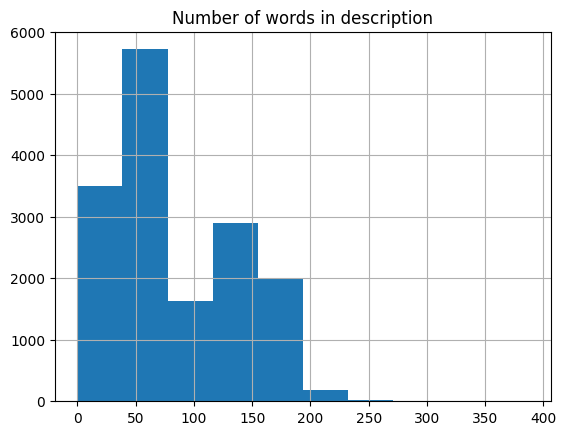

In [169]:
items["description"].apply(
    lambda text: len(text.split())
).hist()\
 .set_title("Number of words in description");

In [170]:
items_features = [Columns.Item, "release_year", "genres", "countries", "for_kids", "age_rating", "studios"]

In [171]:
# длина истории юзера 
candidate_data_train['user_hist'] = (
    candidate_data_train.groupby('user_id')
    ['item_id'].transform('count')
)
# популярность контента
candidate_data_train['item_pop'] = (
    candidate_data_train.groupby('item_id')
    ['user_id'].transform('count')
)
# средняя популярность контента, просматриваемого этим юзером
candidate_data_train['user_avg_pop'] = (
    candidate_data_train.groupby('user_id')
    ['item_pop'].transform('mean')
)
# средняя длина истории пользователей, которые смотрит этот контент
candidate_data_train['item_avg_hist'] = (
    candidate_data_train.groupby('item_id')
    ['user_hist'].transform('mean')
)
# популярность последнего просмотренного контента
candidate_data_train.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)
candidate_data_train['user_last_pop'] = (
    candidate_data_train.groupby('user_id')
    ['item_pop'].transform('first')
)
candidate_data_train.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


In [172]:
candidate_data_train.isnull().sum()

user_id          0
item_id          0
datetime         0
total_dur        0
weight           0
user_hist        0
item_pop         0
user_avg_pop     0
item_avg_hist    0
user_last_pop    0
dtype: int64

In [173]:
items = pd.merge(
    left=items, 
    right=(
        candidate_data_train
        [[Columns.Item, 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users, 
    right=(
        candidate_data_train
        [[Columns.User, 'user_hist', 'user_avg_pop', 'user_last_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)

In [174]:
items_features += ['item_pop', 'item_avg_hist']
users_features += ['user_hist', 'user_avg_pop', 'user_last_pop']

In [250]:
candidates.isnull().sum()

user_id          0
item_id          0
lfm_score        0
rank             0
datetime     91072
total_dur    91072
weight       91072
target           0
dtype: int64

In [401]:
def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    default_values: tp.Dict,
) -> pd.DataFrame:
    
    df = candidates_df[
        candidates_df[Columns.User].isin(user_list)
    ]
    
    df.fillna(default_values, inplace=True)

    df.sort_values(
        by=[Columns.User, Columns.Item],
        inplace=True,
    )
    return df

ranker_train = users_filter(ranker_train_users, candidates, interactions_default_values)
ranker_val = users_filter(ranker_val_users, candidates, interactions_default_values)
ranker_test = users_filter(ranker_test_users, candidates, interactions_default_values)

pd.concat([ranker_train.head(3), ranker_train.tail(3)])

,user_id,item_id,lfm_score,rank,datetime,total_dur,weight,target
3,3,142,4.020828,9,2021-08-13,5892.0,100.0,1
8,3,1418,2.939495,41,2021-07-26,3.0,0.0,1
11,3,2220,2.743337,57,2021-08-04,15588.0,100.0,1
259458,1097544,4151,4.847621,11,2021-07-30,16.0,0.0,1
259460,1097544,7829,3.999884,21,2021-08-04,6540.0,100.0,1
259459,1097544,9996,4.240382,18,2021-07-25,184.0,0.0,1


In [402]:
items[items_features].isnull().sum()

item_id            0
release_year       1
genres             0
countries          0
for_kids           0
age_rating         0
studios            0
item_pop         946
item_avg_hist    946
dtype: int64

In [403]:
users[users_features].isnull().sum()

user_id               0
age                   0
income                0
sex                   0
kids_flg              0
user_hist        275387
user_avg_pop     275387
user_last_pop    275387
dtype: int64

In [404]:
def add_features(df: pd.DataFrame, 
                 users: pd.DataFrame,
                 items: pd.DataFrame,
                 users_features: tp.List[str], 
                 items_features: tp.List[str],
                 default_values: tp.Dict) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users[users_features], 
        how='left', 
        on=[Columns.User]
    )
    df = pd.merge(
        df, 
        items[items_features], 
        how='left', 
        on=[Columns.Item]
    )

    df.fillna(default_values, inplace=True)
    df.fillna(default_values, inplace=True)
    
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)

    return df


default_values = {
    'user_hist': 0,
    'user_avg_pop': candidate_data_train['user_avg_pop'].median(),
    'user_last_pop': candidate_data_train['user_last_pop'].median(),
    'item_pop': candidate_data_train['item_pop'].median(),
    'item_avg_hist': candidate_data_train['item_avg_hist'].median(),
    'release_year': items["release_year"].mode().iloc[0]
}

ranker_train = add_features(ranker_train, users, items, users_features, items_features, default_values)
ranker_val = add_features(ranker_val, users, items, users_features, items_features, default_values)
ranker_test = add_features(ranker_test, users, items, users_features, items_features, default_values)

pd.concat([ranker_train.head(3), ranker_train.tail(3)])

,user_id,item_id,lfm_score,rank,datetime,total_dur,weight,target,age,income,...,user_avg_pop,user_last_pop,release_year,genres,countries,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,142,4.020828,9,2021-08-13,5892.0,100.0,1,-1,-1,...,11957.864865,2858.0,2019.0,"драмы, триллеры",Россия,-1,3,-1,35862.0,15.251464
1,3,1418,2.939495,41,2021-07-26,3.0,0.0,1,-1,-1,...,11957.864865,2858.0,2016.0,ужасы,Великобритания,-1,3,-1,3745.0,25.438718
2,3,2220,2.743337,57,2021-08-04,15588.0,100.0,1,-1,-1,...,11957.864865,2858.0,2019.0,"ужасы, детективы","США, Таиланд",-1,4,-1,3964.0,22.982341
314625,1097544,4151,4.847621,11,2021-07-30,16.0,0.0,1,1,2,...,1106.000000,490.0,2020.0,комедии,Россия,-1,4,-1,69641.0,10.807886
314626,1097544,7829,3.999884,21,2021-08-04,6540.0,100.0,1,1,2,...,1106.000000,490.0,2020.0,"боевики, фантастика, фэнтези, приключения","США, Канада, Люксембург",-1,3,-1,6028.0,18.895322
314627,1097544,9996,4.240382,18,2021-07-25,184.0,0.0,1,1,2,...,1106.000000,490.0,2020.0,драмы,Россия,-1,3,-1,28627.0,13.484787


In [405]:
ranker_train.isnull().sum()

user_id          0
item_id          0
lfm_score        0
rank             0
datetime         0
total_dur        0
weight           0
target           0
age              0
income           0
sex              0
kids_flg         0
user_hist        0
user_avg_pop     0
user_last_pop    0
release_year     0
genres           0
countries        0
for_kids         0
age_rating       0
studios          0
item_pop         0
item_avg_hist    0
dtype: int64

In [406]:
ranker_val.isnull().sum()

user_id          0
item_id          0
lfm_score        0
rank             0
datetime         0
total_dur        0
weight           0
target           0
age              0
income           0
sex              0
kids_flg         0
user_hist        0
user_avg_pop     0
user_last_pop    0
release_year     0
genres           0
countries        0
for_kids         0
age_rating       0
studios          0
item_pop         0
item_avg_hist    0
dtype: int64

In [407]:
ranker_test.isnull().sum()

user_id          0
item_id          0
lfm_score        0
rank             0
datetime         0
total_dur        0
weight           0
target           0
age              0
income           0
sex              0
kids_flg         0
user_hist        0
user_avg_pop     0
user_last_pop    0
release_year     0
genres           0
countries        0
for_kids         0
age_rating       0
studios          0
item_pop         0
item_avg_hist    0
dtype: int64

In [408]:
ranker_train.to_csv(f'../data/ranker_train.csv', index=False)
ranker_val.to_csv(f'../data/ranker_val.csv', index=False)
ranker_test.to_csv(f'../data/ranker_test.csv', index=False)

# Second Level Model

In [409]:
from catboost import CatBoostClassifier

In [427]:
ranker_train = pd.read_csv(f'../data/ranker_train.csv')
ranker_val = pd.read_csv(f'../data/ranker_val.csv')
ranker_test = pd.read_csv(f'../data/ranker_test.csv')

In [428]:
cols = ['lfm_score', 'rank', 'age',
       'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop',
       'user_last_pop', 'release_year', 'genres', 'countries', 'for_kids',
       'age_rating', 'studios', 'item_pop', 'item_avg_hist', 'target']
text_cols = ['genres', 'countries']

In [429]:
ranker_train = ranker_train[cols]
ranker_val = ranker_val[cols]
ranker_test = ranker_test[Columns.UserItem + cols]

## Pointwise

In [376]:
X_train, y_train = ranker_train.drop("target", axis=1), ranker_train["target"]
X_val, y_val = ranker_val.drop("target", axis=1), ranker_val["target"]

In [377]:
TRACKING_URI = "http://localhost:5555/"
NAME_EXPERIMENT = "Second-Level-Model"

mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(NAME_EXPERIMENT)

<Experiment: artifact_location='s3://mlflow/3', creation_time=1681555590330, experiment_id='3', last_update_time=1681555590330, lifecycle_stage='active', name='Second-Level-Model', tags={}>

In [378]:
mlflow.get_registry_uri(), mlflow.get_tracking_uri()

('http://localhost:5555/', 'http://localhost:5555/')

In [381]:
MODEL_NAME = f"CBM_PointWise"
TIMESTAMP = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")

cbm_params = {
    'n_estimators': 3000,
    'custom_loss': ['AUC', 'Recall', 'Precision', 'Accuracy'],
    'random_seed': 17,
    'learning_rate': 0.1,
    'thread_count': 4,
    'verbose': 100,
    'max_depth': 4,
    'subsample': 0.9,
    'train_dir': f'./{MODEL_NAME}-{TIMESTAMP}/'
}

mlflow.start_run()
mlflow.set_tag("mlflow.runName", f"{MODEL_NAME}-{TIMESTAMP}")
mlflow.log_params(cbm_params)

In [382]:
cbm_model = CatBoostClassifier(**cbm_params)

cbm_model.fit(X_train, y_train, 
              eval_set=(X_val, y_val),
              early_stopping_rounds=100, 
              text_features=text_cols)

0:	learn: 0.6698174	test: 0.6699493	best: 0.6699493 (0)	total: 101ms	remaining: 5m 2s
100:	learn: 0.5394680	test: 0.5396787	best: 0.5396787 (100)	total: 7.78s	remaining: 3m 43s
200:	learn: 0.5311330	test: 0.5317121	best: 0.5317121 (200)	total: 14.9s	remaining: 3m 27s
300:	learn: 0.5265746	test: 0.5278098	best: 0.5278098 (300)	total: 21.9s	remaining: 3m 16s
400:	learn: 0.5229497	test: 0.5248114	best: 0.5248114 (400)	total: 29.6s	remaining: 3m 11s
500:	learn: 0.5202733	test: 0.5227743	best: 0.5227743 (500)	total: 37.2s	remaining: 3m 5s
600:	learn: 0.5180377	test: 0.5211959	best: 0.5211959 (600)	total: 44.7s	remaining: 2m 58s
700:	learn: 0.5161746	test: 0.5200838	best: 0.5200838 (700)	total: 52.1s	remaining: 2m 50s
800:	learn: 0.5144493	test: 0.5189059	best: 0.5189040 (799)	total: 59.5s	remaining: 2m 43s
900:	learn: 0.5130855	test: 0.5182399	best: 0.5182389 (899)	total: 1m 6s	remaining: 2m 35s
1000:	learn: 0.5118405	test: 0.5176345	best: 0.5176345 (1000)	total: 1m 14s	remaining: 2m 28s
11

In [328]:
with open("../service/weights/cbm/cbm_pointwise.dill", "wb") as file:
    dill.dump(cbm_model, file)

In [384]:
import json


with open(f'./{MODEL_NAME}-{TIMESTAMP}/catboost_training.json') as f:
    catboost_training = json.load(f)

In [385]:
test_metric = [metric["name"] for metric in catboost_training["meta"]["test_metrics"]]
train_metric = [metric["name"] for metric in catboost_training["meta"]["learn_metrics"]]

In [388]:
for i, iteration in enumerate(catboost_training["iterations"]):
    log = dict()
    log["Epoch"] = i + 1
    for name, value in zip(train_metric, iteration["learn"]):
        log[f"Learn_{name}"] = value
    for name, value in zip(test_metric, iteration["test"]):
        log[f"Test_{name}"] = value
    log["Test_Result"] = 0.1*log["Test_Recall"]+0.9*log["Test_AUC"]
    mlflow.log_metrics(log)

In [389]:
mlflow.end_run()

In [390]:
import shap
import matplotlib.pyplot as plt
from catboost import Pool

In [391]:
X_train_sample, _, y_train_sample, _ =train_test_split(X_train, y_train, test_size=0.8, random_state=17)

shap_values = cbm_model.get_feature_importance(
    Pool(
        X_train_sample, 
        y_train_sample, 
        text_features=text_cols
    ),
    type="ShapValues"
)

In [392]:
expected_values = shap_values[0, -1]
shap_values = shap_values[:, :-1]

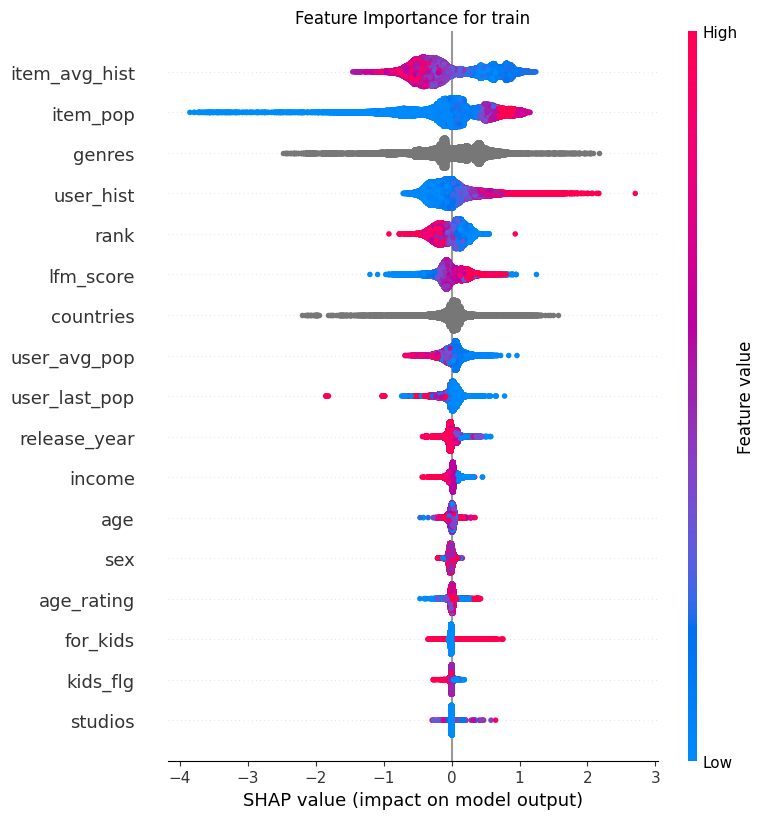

In [393]:
plt.title("Feature Importance for train")

shap.summary_plot(shap_values, X_train_sample)

In [394]:
y_pred: np.ndarray = cbm_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test['target'])

y_pred

array([0.52377324, 0.50377044, 0.50613816, ..., 0.12349867, 0.86639724,
       0.60779854])

In [430]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=[Columns.User, f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    return df

ranker_test = add_score_and_rank(ranker_test, y_pred, 'pointwise')
ranker_test.head(3)

,user_id,item_id,lfm_score,rank,age,income,sex,kids_flg,user_hist,user_avg_pop,...,genres,countries,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank
0,21,1819,1.578131,72,3,2,0,0,26.0,14222.346154,...,комедии,Россия,-1,3,-1,9792.0,14.719669,0,0.523773,1
1,21,13787,1.434620,84,3,2,0,0,26.0,14222.346154,...,"семейное, приключения",Нидерланды,-1,2,-1,1707.0,26.000586,1,0.503770,2
2,51,8636,3.109038,56,1,2,0,0,3.0,6925.666667,...,"драмы, спорт",Россия,-1,1,-1,28660.0,14.080984,1,0.506138,1


In [431]:
from sklearn.metrics import roc_auc_score

print("Roc-Auc не усредненный по юзерам:", roc_auc_score(y_true, y_pred))

Roc-Auc не усредненный по юзерам: 0.8165937874229253


In [432]:
def avg_user_metric(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        user_ids: np.ndarray,
        metric_function: tp.Callable[[np.ndarray, np.ndarray], float],
) -> float:
    """
    Вычисляем метрику, усредненную по всем значимым (есть разные таргеты) группам.

    :param y_true: список таргетов
    :param y_pred: список предсказаний
    :param user_ids: список групп (обычно это список user_id той же размерности, что и предсказания и таргеты)
    :param metric_function: усредняемая метрика(y_true, y_pred) -> float
    :return: значение метрики metric_function, усредненное по всем значимым группам
    """
    avg_score: float = 0.

    if len(y_pred) == len(y_true) == len(user_ids):
        l_ind: int = 0
        cur_group_id: int = user_ids[0] if len(user_ids) else 0
        n_groups: int = 0
        for r_ind, group_id in enumerate(user_ids):
            if group_id != cur_group_id or r_ind == len(user_ids) - 1:
                if r_ind == len(user_ids) - 1:
                    r_ind += 1
                # Если группа не состоит из одного и того же таргета - добавляем ее
                group_true = y_true[l_ind: r_ind]
                if not np.all(group_true == group_true[0]):
                    avg_score += metric_function(group_true, y_pred[l_ind: r_ind])
                    n_groups += 1
                l_ind = r_ind
                cur_group_id = group_id
        avg_score /= max(1, n_groups)
    else:
        raise ValueError(f'Размерности не совпадают: '
                         f'y_pred - {len(y_pred)}, y_true - {len(y_true)}, user_ids - {len(user_ids)}')
    return avg_score

In [433]:
# усредненный рок аук по юзерам
# df должен быть отсортирован по user_id
avg_user_metric(
    y_true=np.array(ranker_test['target']),
    y_pred=np.array(ranker_test['pointwise_score']),
    user_ids=np.array(ranker_test['user_id']),
    metric_function=roc_auc_score
)
# Ранкер вроде ранжирует, но вот весь пайплайн в целом - не очень

0.822829838756681

In [438]:
ranker_test[Columns.UserItem + [Columns.Rank, "pointwise_rank"]].head(30)

,user_id,item_id,rank,pointwise_rank
0,21,1819,72,1
1,21,13787,84,2
2,51,8636,56,1
4,53,3734,7,1
5,53,4151,10,2
3,53,142,44,3
8,60,15297,12,1
7,60,3808,32,2
6,60,1179,83,3
14,229,15297,2,1


In [442]:
metrics_pipelins["cbm_pointwise"] = calc_metrics(
    metrics,
    reco=ranker_test[
        ranker_test[Columns.User].isin(ranker_test_users)
    ][Columns.UserItem + ["pointwise_rank"]].rename(columns={"pointwise_rank": Columns.Rank}),
    interactions=ranker_data[ranker_data[Columns.User].isin(ranker_test_users)],
    prev_interactions=candidate_data_train[candidate_data_train[Columns.User].isin(ranker_test_users)],
    catalog=items[Columns.Item].unique()
)

pd.DataFrame(metrics_pipelins)

,lfm,cbm_pointwise
prec@10,0.019379,0.059049
recall@10,0.065137,0.162770
NDCG@10,0.020741,0.094806
MAP@10,0.024644,0.153888
novelty,4.858383,5.579798
serendipity,0.000058,0.001992


In [440]:
ranker_test[
    ranker_test[Columns.User].isin(ranker_test_users)
].rename(columns={"pointwise_rank": Columns.Rank})

,user_id,item_id,lfm_score,rank,age,income,sex,kids_flg,user_hist,user_avg_pop,...,genres,countries,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,rank
0,21,1819,1.578131,72,3,2,0,0,26.0,14222.346154,...,комедии,Россия,-1,3,-1,9792.0,14.719669,0,0.523773,1
1,21,13787,1.434620,84,3,2,0,0,26.0,14222.346154,...,"семейное, приключения",Нидерланды,-1,2,-1,1707.0,26.000586,1,0.503770,2
2,51,8636,3.109038,56,1,2,0,0,3.0,6925.666667,...,"драмы, спорт",Россия,-1,1,-1,28660.0,14.080984,1,0.506138,1
4,53,3734,3.705733,7,3,2,1,0,10.0,39954.300000,...,комедии,Россия,-1,3,-1,50004.0,12.134949,1,0.846067,1
5,53,4151,3.372143,10,3,2,1,0,10.0,39954.300000,...,комедии,Россия,-1,4,-1,69641.0,10.807886,1,0.810902,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67609,1097337,8636,2.392168,85,1,3,1,0,11.0,46314.909091,...,"драмы, спорт",Россия,-1,1,-1,28660.0,14.080984,1,0.694564,1
67610,1097337,14703,2.868525,47,1,3,1,0,11.0,46314.909091,...,триллеры,США,-1,4,-1,14897.0,18.058670,0,0.519927,2
67611,1097344,13921,1.789975,93,2,3,0,1,19.0,29033.315789,...,"драмы, семейное, комедии","Италия, Испания",-1,2,-1,664.0,26.368976,0,0.123499,1
67612,1097355,4151,4.225960,9,0,2,0,1,2.0,52575.000000,...,комедии,Россия,-1,4,-1,69641.0,10.807886,0,0.866397,1


In [443]:
(metrics_pipelins)

{'lfm': {'prec@10': 0.019379000199530337,
  'recall@10': 0.0651374696735962,
  'NDCG@10': 0.020741388789194935,
  'MAP@10': 0.024643776524250212,
  'novelty': 4.858382607402586,
  'serendipity': 5.756522960560939e-05},
 'cbm_pointwise': {'prec@10': 0.05904870075054104,
  'recall@10': 0.16276970410942257,
  'NDCG@10': 0.09480561414348401,
  'MAP@10': 0.1538882207955439,
  'novelty': 5.579797517876016,
  'serendipity': 0.0019923213230229465}}

# Save LightFM embeddings

In [456]:
import numpy as np

In [449]:
with open("../service/weights/lfm/lightFM-64-warp.dill", "rb") as file:
    lfm_model = dill.load(file)
lfm_model

In [455]:
user_biases, user_embeddings = lfm_model.get_user_representations()
item_biases, item_embeddings = lfm_model.get_item_representations()
(
    user_biases.shape, user_embeddings.shape,
    item_biases.shape, item_embeddings.shape
)

((720875,), (720875, 64), (15017,), (15017, 64))

In [474]:
user_embeddings = np.hstack((user_biases[:, np.newaxis], np.ones((user_biases.size, 1)), user_embeddings))
item_embeddings = np.hstack((np.ones((item_biases.size, 1)), item_biases[:, np.newaxis], item_embeddings))
user_embeddings.shape, item_embeddings.shape

((720875, 66), (15017, 66))

In [475]:
def augment_inner_product(factors):
    normed_factors = np.linalg.norm(factors, axis=1)
    max_norm = normed_factors.max()
    
    extra_dim = np.sqrt(max_norm ** 2 - normed_factors ** 2).reshape(-1, 1)
    augmented_factors = np.append(factors, extra_dim, axis=1)
    return max_norm, augmented_factors

In [479]:
_, augmented_item_embeddings = augment_inner_product(item_embeddings)

extra_zero = np.zeros((user_embeddings.shape[0], 1))
augmented_user_embeddings = np.append(user_embeddings, extra_zero, axis=1)

augmented_user_embeddings.shape, augmented_item_embeddings.shape

((720875, 67), (15017, 67))

In [480]:
with open("../service/weights/lfm/lfm_users.npy", "wb") as file:
    np.save(file, augmented_user_embeddings)
    
with open("../service/weights/lfm/lfm_items.npy", "wb") as file:
    np.save(file, augmented_item_embeddings)

In [481]:
augmented_user_embeddings_load = np.load("../service/weights/lfm/lfm_users.npy")
augmented_item_embeddings_load = np.load("../service/weights/lfm/lfm_items.npy")

assert augmented_user_embeddings.shape == augmented_user_embeddings_load.shape, "Different dims in user embs"
assert augmented_item_embeddings.shape == augmented_item_embeddings_load.shape, "Different dims in item embs"

In [482]:
augmented_user_embeddings_load

array([[-5.70470715,  1.        , -0.08844543, ...,  0.89753747,
        -0.09343429,  0.        ],
       [-5.50620604,  1.        , -0.36355931, ...,  1.23938358,
        -0.46550316,  0.        ],
       [-0.92452252,  1.        ,  0.18279359, ..., -0.43287361,
        -0.19109122,  0.        ],
       ...,
       [-1.0539819 ,  1.        ,  0.20218004, ..., -0.38927931,
         0.28014761,  0.        ],
       [-0.74193805,  1.        ,  0.29182979, ..., -0.45745394,
         0.37749994,  0.        ],
       [-0.85181928,  1.        ,  0.59533429, ..., -0.39235401,
         0.6542446 ,  0.        ]])

In [483]:
augmented_item_embeddings_load

array([[ 1.        ,  2.13100839,  0.52686369, ...,  0.52406681,
        -0.24196471,  4.57020001],
       [ 1.        ,  0.82850194, -0.17107055, ...,  0.77371764,
         0.29579756,  4.55155011],
       [ 1.        ,  4.13174009, -0.16906542, ..., -0.14560443,
        -0.2704978 ,  3.71411574],
       ...,
       [ 1.        , -1.64954901, -0.21719487, ...,  0.61060119,
        -0.42309901,  4.80102964],
       [ 1.        , -1.53882587,  0.28095448, ..., -0.35808912,
         0.20192778,  5.0702974 ],
       [ 1.        , -1.58048201, -0.56908399, ...,  0.28681993,
         0.35446817,  4.93692627]])

# Learn ranker on all Data for ranker

In [495]:
ranker_train = pd.read_csv(f'../data/ranker_train.csv')
ranker_val = pd.read_csv(f'../data/ranker_val.csv')
ranker_test = pd.read_csv(f'../data/ranker_test.csv')

In [497]:
assert len(ranker_train.columns) == len(ranker_val.columns) == len(ranker_test.columns), "Diff len col"

In [499]:
ranker_all_data = pd.concat(
    [ranker_train, ranker_val, ranker_test],
    ignore_index=True
)
ranker_all_data.shape

(449664, 23)

In [500]:
ranker_all_data.target.value_counts(normalize=True)

1    0.577011
0    0.422989
Name: target, dtype: float64

In [501]:
ranker_all_data.isnull().sum()

user_id          0
item_id          0
lfm_score        0
rank             0
datetime         0
total_dur        0
weight           0
target           0
age              0
income           0
sex              0
kids_flg         0
user_hist        0
user_avg_pop     0
user_last_pop    0
release_year     0
genres           0
countries        0
for_kids         0
age_rating       0
studios          0
item_pop         0
item_avg_hist    0
dtype: int64

In [507]:
train_users, val_users = train_test_split(
    ranker_all_data[Columns.User].unique(),
    test_size=0.1,
    random_state=17
)

In [509]:
train_users.shape, val_users.shape

((151749,), (16861,))

In [514]:
ranker_all_data[ranker_all_data[Columns.User].isin(train_users)].target.value_counts(normalize=True)

1    0.57703
0    0.42297
Name: target, dtype: float64

In [515]:
ranker_all_data[ranker_all_data[Columns.User].isin(val_users)].target.value_counts(normalize=True)

1    0.576834
0    0.423166
Name: target, dtype: float64

In [516]:
ranker_all_data_train = ranker_all_data[ranker_all_data[Columns.User].isin(train_users)]
ranker_all_data_val = ranker_all_data[ranker_all_data[Columns.User].isin(val_users)]

In [530]:
cols = ['lfm_score', 'rank', 'age',
       'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop',
       'user_last_pop', 'release_year', 'genres', 'countries', 'for_kids',
       'age_rating', 'studios', 'item_pop', 'item_avg_hist', 'target']
text_cols = ['genres', 'countries']

In [531]:
X_train, y_train = ranker_all_data_train[cols].drop("target", axis=1), ranker_all_data_train["target"]
X_val, y_val = ranker_all_data_val[cols].drop("target", axis=1), ranker_all_data_val["target"]

In [532]:
TRACKING_URI = "http://localhost:5555/"
NAME_EXPERIMENT = "Second-Level-Model"

mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(NAME_EXPERIMENT)

<Experiment: artifact_location='s3://mlflow/3', creation_time=1681555590330, experiment_id='3', last_update_time=1681555590330, lifecycle_stage='active', name='Second-Level-Model', tags={}>

In [533]:
mlflow.get_registry_uri(), mlflow.get_tracking_uri()

('http://localhost:5555/', 'http://localhost:5555/')

In [535]:
MODEL_NAME = f"CBM_PointWise_all_data"
TIMESTAMP = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")

cbm_params = {
    'n_estimators': 3000,
    'custom_loss': ['AUC', 'Recall', 'Precision', 'Accuracy'],
    'random_seed': 17,
    'learning_rate': 0.1,
    'thread_count': 4,
    'verbose': 100,
    'max_depth': 4,
    'subsample': 0.9,
    'train_dir': f'./{MODEL_NAME}-{TIMESTAMP}/'
}

mlflow.start_run()
mlflow.set_tag("mlflow.runName", f"{MODEL_NAME}-{TIMESTAMP}")
mlflow.log_params(cbm_params)

In [536]:
cbm_model = CatBoostClassifier(**cbm_params)

cbm_model.fit(X_train, y_train, 
              eval_set=(X_val, y_val),
              early_stopping_rounds=100, 
              text_features=text_cols)

0:	learn: 0.6699075	test: 0.6696706	best: 0.6696706 (0)	total: 134ms	remaining: 6m 41s
100:	learn: 0.5394170	test: 0.5385287	best: 0.5385287 (100)	total: 9.92s	remaining: 4m 44s
200:	learn: 0.5317643	test: 0.5317213	best: 0.5317213 (200)	total: 18.8s	remaining: 4m 22s
300:	learn: 0.5271023	test: 0.5275936	best: 0.5275936 (300)	total: 27.7s	remaining: 4m 8s
400:	learn: 0.5237225	test: 0.5247489	best: 0.5247489 (400)	total: 36.6s	remaining: 3m 57s
500:	learn: 0.5209598	test: 0.5224014	best: 0.5224014 (500)	total: 45.6s	remaining: 3m 47s
600:	learn: 0.5186886	test: 0.5206102	best: 0.5206102 (600)	total: 54.7s	remaining: 3m 38s
700:	learn: 0.5169337	test: 0.5193760	best: 0.5193760 (700)	total: 1m 3s	remaining: 3m 29s
800:	learn: 0.5154906	test: 0.5183906	best: 0.5183906 (800)	total: 1m 12s	remaining: 3m 19s
900:	learn: 0.5142844	test: 0.5176790	best: 0.5176790 (900)	total: 1m 21s	remaining: 3m 10s
1000:	learn: 0.5131120	test: 0.5170121	best: 0.5170121 (1000)	total: 1m 31s	remaining: 3m 2s


In [537]:
y_pred_val: np.ndarray = cbm_model.predict_proba(X_val)[:, 1]
print("Roc-Auc не усредненный по юзерам:", roc_auc_score(y_val, y_pred_val))

Roc-Auc не усредненный по юзерам: 0.8202549788351434


In [538]:
with open(f'./{MODEL_NAME}-{TIMESTAMP}/catboost_training.json') as f:
    catboost_training = json.load(f)
    
test_metric = [metric["name"] for metric in catboost_training["meta"]["test_metrics"]]
train_metric = [metric["name"] for metric in catboost_training["meta"]["learn_metrics"]]

for i, iteration in enumerate(catboost_training["iterations"]):
    log = dict()
    log["Epoch"] = i + 1
    for name, value in zip(train_metric, iteration["learn"]):
        log[f"Learn_{name}"] = value
    for name, value in zip(test_metric, iteration["test"]):
        log[f"Test_{name}"] = value
    log["Test_Result"] = 0.1*log["Test_Recall"]+0.9*log["Test_AUC"]
    mlflow.log_metrics(log)
    
mlflow.end_run()

In [540]:
with open("../service/weights/pointwise/cbm_pointwise_all_data.dill", "wb") as file:
    dill.dump(cbm_model, file)

In [555]:
items

,item_id,content_type,title,release_year,genres,countries,for_kids,age_rating,studios,description,keywords,item_pop,item_avg_hist
0,10711,0,Поговори с ней,1983.0,"драмы, зарубежные, детективы, мелодрамы",Испания,-1,3,-1,Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",4.0,63.250000
1,2508,0,Голые перцы,2012.0,"зарубежные, приключения, комедии",США,-1,3,-1,Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...",9.0,75.222222
2,10716,0,Тактическая сила,2009.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,-1,3,-1,Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...",6.0,65.666667
3,7868,0,45 лет,2014.0,"драмы, зарубежные, мелодрамы",Великобритания,-1,3,-1,"Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...",2.0,88.000000
4,16268,0,Все решает мгновение,1897.0,"драмы, спорт, советские, мелодрамы",СССР,-1,2,33,Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...",1.0,28.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,6443,1,Полярный круг,2016.0,"драмы, триллеры, криминал","Финляндия, Германия",-1,3,-1,"Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н...",6112.0,19.302029
15959,2367,1,Надежда,2019.0,"драмы, боевики",Россия,0,4,-1,Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия",235.0,28.642553
15960,10632,1,Сговор,2016.0,"драмы, триллеры, криминал",Россия,0,4,-1,Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия",38.0,52.842105
15961,4538,1,Среди камней,2018.0,"драмы, спорт, криминал",Россия,0,4,-1,Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия",94.0,26.968085


In [558]:
users

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN
3,721985,3,2,0,0,13.0,6009.461538,446.0
4,704055,2,4,0,0,7.0,531.571429,68.0
...,...,...,...,...,...,...,...,...
840192,339025,5,0,0,0,NaN,NaN,NaN
840193,983617,0,2,0,1,NaN,NaN,NaN
840194,251008,-1,-1,-1,0,NaN,NaN,NaN
840195,590706,-1,-1,0,0,NaN,NaN,NaN


In [560]:
set(cols) - set(users.columns)

{'age_rating',
 'countries',
 'for_kids',
 'genres',
 'item_avg_hist',
 'item_pop',
 'lfm_score',
 'rank',
 'release_year',
 'studios',
 'target'}

In [570]:
items_cols = [Columns.Item, "age_rating", "countries", "for_kids",
              "genres", "item_avg_hist", "item_pop", 
              "release_year", "studios"]

In [571]:
items_bd = items[items_cols]
items_bd.head()

,item_id,age_rating,countries,for_kids,genres,item_avg_hist,item_pop,release_year,studios
0,10711,3,Испания,-1,"драмы, зарубежные, детективы, мелодрамы",63.250000,4.0,1983.0,-1
1,2508,3,США,-1,"зарубежные, приключения, комедии",75.222222,9.0,2012.0,-1
2,10716,3,Канада,-1,"криминал, зарубежные, триллеры, боевики, комедии",65.666667,6.0,2009.0,-1
3,7868,3,Великобритания,-1,"драмы, зарубежные, мелодрамы",88.000000,2.0,2014.0,-1
4,16268,2,СССР,-1,"драмы, спорт, советские, мелодрамы",28.000000,1.0,1897.0,33


In [572]:
set(cols) - set(users.columns) - set(items_bd.columns)

{'lfm_score', 'rank', 'target'}

In [567]:
items_bd.isnull().sum()

item_id            0
age_rating         0
age_rating         0
for_kids           0
genres             0
item_avg_hist    946
item_pop         946
release_year       1
studios            0
dtype: int64

In [568]:
users.isnull().sum()

user_id               0
age                   0
income                0
sex                   0
kids_flg              0
user_hist        275387
user_avg_pop     275387
user_last_pop    275387
dtype: int64

In [573]:
users_bd = users.copy()

In [574]:
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': candidate_data_train['user_avg_pop'].median(),
    'user_last_pop': candidate_data_train['user_last_pop'].median()
}

default_values_items = {
    'item_pop': candidate_data_train['item_pop'].median(),
    'item_avg_hist': candidate_data_train['item_avg_hist'].median(),
    'release_year': items["release_year"].mode().iloc[0]
}

users_bd.fillna(default_values_users, inplace=True)
items_bd.fillna(default_values_items, inplace=True)

In [575]:
users_bd.isnull().sum()

user_id          0
age              0
income           0
sex              0
kids_flg         0
user_hist        0
user_avg_pop     0
user_last_pop    0
dtype: int64

In [576]:
items_bd.isnull().sum()

item_id          0
age_rating       0
countries        0
for_kids         0
genres           0
item_avg_hist    0
item_pop         0
release_year     0
studios          0
dtype: int64

In [577]:
ranker_all_data.to_csv("../data/kion_train/ranker_data.csv", index=False)
users_bd.to_csv("../data/kion_train/users_features.csv", index=False)
items_bd.to_csv("../data/kion_train/items_features.csv", index=False)

In [623]:
users_bd[users_bd[Columns.User] == 973171.0]

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.8,93403.0


In [626]:
items_bd[items_bd[Columns.Item].isin(items_bd[Columns.Item].iloc[:10].tolist())]

,item_id,age_rating,countries,for_kids,genres,item_avg_hist,item_pop,release_year,studios
0,10711,3,Испания,-1,"драмы, зарубежные, детективы, мелодрамы",63.250000,4.0,1983.0,-1
1,2508,3,США,-1,"зарубежные, приключения, комедии",75.222222,9.0,2012.0,-1
2,10716,3,Канада,-1,"криминал, зарубежные, триллеры, боевики, комедии",65.666667,6.0,2009.0,-1
3,7868,3,Великобритания,-1,"драмы, зарубежные, мелодрамы",88.000000,2.0,2014.0,-1
4,16268,2,СССР,-1,"драмы, спорт, советские, мелодрамы",28.000000,1.0,1897.0,33
5,854,3,Россия,-1,"драмы, русские",22.675978,2846.0,2014.0,-1
6,1468,1,СССР,-1,"фильмы, сказки, приключения, советские, семейн...",26.000000,3.0,1897.0,-1
7,11114,1,США,-1,"для детей, сказки, полнометражные, зарубежные,...",92.555556,9.0,2014.0,23
8,9853,3,Испания,-1,"криминал, детективы, драмы, зарубежные, триллеры",75.000000,21.0,2016.0,-1
9,8604,2,Россия,-1,"русские, мелодрамы",386.000000,2.0,2012.0,-1


In [631]:
items_bd[items_bd[Columns.Item].isin(items_bd[Columns.Item].iloc[:10].tolist())]

,item_id,age_rating,countries,for_kids,genres,item_avg_hist,item_pop,release_year,studios
0,10711,3,Испания,-1,"драмы, зарубежные, детективы, мелодрамы",63.250000,4.0,1983.0,-1
1,2508,3,США,-1,"зарубежные, приключения, комедии",75.222222,9.0,2012.0,-1
2,10716,3,Канада,-1,"криминал, зарубежные, триллеры, боевики, комедии",65.666667,6.0,2009.0,-1
3,7868,3,Великобритания,-1,"драмы, зарубежные, мелодрамы",88.000000,2.0,2014.0,-1
4,16268,2,СССР,-1,"драмы, спорт, советские, мелодрамы",28.000000,1.0,1897.0,33
5,854,3,Россия,-1,"драмы, русские",22.675978,2846.0,2014.0,-1
6,1468,1,СССР,-1,"фильмы, сказки, приключения, советские, семейн...",26.000000,3.0,1897.0,-1
7,11114,1,США,-1,"для детей, сказки, полнометражные, зарубежные,...",92.555556,9.0,2014.0,23
8,9853,3,Испания,-1,"криминал, детективы, драмы, зарубежные, триллеры",75.000000,21.0,2016.0,-1
9,8604,2,Россия,-1,"русские, мелодрамы",386.000000,2.0,2012.0,-1


In [633]:
items_bd[items_bd[Columns.Item].isin(items_bd[Columns.Item].iloc[:10].tolist())].append(
    users_bd[users_bd[Columns.User] == 973171.0],
)

,item_id,age_rating,countries,for_kids,genres,item_avg_hist,item_pop,release_year,studios,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,10711.0,3,Испания,-1,"драмы, зарубежные, детективы, мелодрамы",63.250000,4.0,1983.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2508.0,3,США,-1,"зарубежные, приключения, комедии",75.222222,9.0,2012.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10716.0,3,Канада,-1,"криминал, зарубежные, триллеры, боевики, комедии",65.666667,6.0,2009.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7868.0,3,Великобритания,-1,"драмы, зарубежные, мелодрамы",88.000000,2.0,2014.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16268.0,2,СССР,-1,"драмы, спорт, советские, мелодрамы",28.000000,1.0,1897.0,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,854.0,3,Россия,-1,"драмы, русские",22.675978,2846.0,2014.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1468.0,1,СССР,-1,"фильмы, сказки, приключения, советские, семейн...",26.000000,3.0,1897.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,11114.0,1,США,-1,"для детей, сказки, полнометражные, зарубежные,...",92.555556,9.0,2014.0,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9853.0,3,Испания,-1,"криминал, детективы, драмы, зарубежные, триллеры",75.000000,21.0,2016.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,8604.0,2,Россия,-1,"русские, мелодрамы",386.000000,2.0,2012.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [639]:
a = pd.DataFrame(np.repeat(users_bd[users_bd[Columns.User] == 973171.0].values, 10, axis=0))
a.columns = users_bd.columns
a

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0
1,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0
2,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0
3,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0
4,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0
5,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0
6,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0
7,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0
8,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0
9,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0


In [640]:
pd.concat(
    [
        a,
        items_bd[items_bd[Columns.Item].isin(items_bd[Columns.Item].iloc[:10].tolist())]
    ],
    axis=1
)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop,item_id,age_rating,countries,for_kids,genres,item_avg_hist,item_pop,release_year,studios
0,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0,10711,3,Испания,-1,"драмы, зарубежные, детективы, мелодрамы",63.250000,4.0,1983.0,-1
1,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0,2508,3,США,-1,"зарубежные, приключения, комедии",75.222222,9.0,2012.0,-1
2,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0,10716,3,Канада,-1,"криминал, зарубежные, триллеры, боевики, комедии",65.666667,6.0,2009.0,-1
3,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0,7868,3,Великобритания,-1,"драмы, зарубежные, мелодрамы",88.000000,2.0,2014.0,-1
4,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0,16268,2,СССР,-1,"драмы, спорт, советские, мелодрамы",28.000000,1.0,1897.0,33
5,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0,854,3,Россия,-1,"драмы, русские",22.675978,2846.0,2014.0,-1
6,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0,1468,1,СССР,-1,"фильмы, сказки, приключения, советские, семейн...",26.000000,3.0,1897.0,-1
7,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0,11114,1,США,-1,"для детей, сказки, полнометражные, зарубежные,...",92.555556,9.0,2014.0,23
8,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0,9853,3,Испания,-1,"криминал, детективы, драмы, зарубежные, триллеры",75.000000,21.0,2016.0,-1
9,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0,8604,2,Россия,-1,"русские, мелодрамы",386.000000,2.0,2012.0,-1


# Check download model pointwise Catboost

In [491]:
import dill

In [541]:
with open("../service/weights/pointwise/cbm_pointwise_all_data.dill", "rb") as file:
    cbm_load = dill.load(file)
cbm_load

In [583]:
users_bd.iloc[0].values[1:]

array([1.00000e+00, 4.00000e+00, 1.00000e+00, 1.00000e+00, 5.00000e+00,
       1.95508e+04, 9.34030e+04])

In [584]:
items_bd.iloc[0].values[1:]

array([3, 'Испания', -1, 'драмы, зарубежные, детективы, мелодрамы', 63.25,
       4.0, 1983.0, -1], dtype=object)

In [591]:
a = list(users_bd.iloc[0].values[1:]) + list(items_bd.iloc[0].values[1:])
a

[1.0,
 4.0,
 1.0,
 1.0,
 5.0,
 19550.8,
 93403.0,
 3,
 'Испания',
 -1,
 'драмы, зарубежные, детективы, мелодрамы',
 63.25,
 4.0,
 1983.0,
 -1]

In [593]:
np.array([a])

array([['1.0', '4.0', '1.0', '1.0', '5.0', '19550.8', '93403.0', '3',
        'Испания', '-1', 'драмы, зарубежные, детективы, мелодрамы',
        '63.25', '4.0', '1983.0', '-1']], dtype='<U39')

In [604]:
users_bd.loc[0][1:]

age                  1.0
income               4.0
sex                  1.0
kids_flg             1.0
user_hist            5.0
user_avg_pop     19550.8
user_last_pop    93403.0
Name: 0, dtype: float64

In [602]:
pd.DataFrame(users_bd.loc[0]).T

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171.0,1.0,4.0,1.0,1.0,5.0,19550.8,93403.0


In [618]:
a = pd.DataFrame(
    pd.concat([users_bd.iloc[0][1:], items_bd.iloc[0][1:]], axis=0)
).T
a["lfm_score"] = 4.258838
a[Columns.Rank] = 9.0

In [619]:
y_pred = cbm_load.predict_proba(X_val)[:, 1]
y_pred

array([0.87320052, 0.38756134, 0.2068651 , ..., 0.75694339, 0.28761449,
       0.51554958])

In [641]:
y_pred[:10]

array([0.87320052, 0.38756134, 0.2068651 , 0.24854347, 0.81682447,
       0.3120707 , 0.81270934, 0.46449974, 0.57496813, 0.95114305])

In [651]:
y_pred[:10][np.argsort(y_pred[:10])]

array([0.2068651 , 0.24854347, 0.3120707 , 0.38756134, 0.46449974,
       0.57496813, 0.81270934, 0.81682447, 0.87320052, 0.95114305])

In [659]:
list(items["item_id"].iloc[:10].values[np.argsort(y_pred[:10])[::-1]])

[8604, 10711, 16268, 1468, 9853, 11114, 2508, 854, 7868, 10716]

In [653]:
np.argsort(y_pred[:10])[::-1]

array([9, 0, 4, 6, 8, 7, 1, 5, 3, 2])

In [652]:
y_pred[:10][np.argsort(y_pred[:10])[::-1]]

array([0.95114305, 0.87320052, 0.81682447, 0.81270934, 0.57496813,
       0.46449974, 0.38756134, 0.3120707 , 0.24854347, 0.2068651 ])

In [646]:
np.sort(y_pred[:10])[1]

0.24854346958603926

In [642]:
y_pred[:10][np.sort(np.unique(y_pred[:10], return_index=True)[1])].tolist()

[0.8732005191322968,
 0.38756133516912195,
 0.20686510026736793,
 0.24854346958603926,
 0.8168244738301077,
 0.31207069929659587,
 0.8127093363796314,
 0.4644997427884185,
 0.5749681264197697,
 0.9511430482328379]

In [620]:
cbm_load.predict_proba(a[X_val.columns])[:, 1]

array([0.0150986])

In [613]:
X_val[["lfm_score", Columns.Rank]].iloc[0]

lfm_score    4.258838
rank         9.000000
Name: 18, dtype: float64

In [610]:
X_val.columns

Index(['lfm_score', 'rank', 'age', 'income', 'sex', 'kids_flg', 'user_hist',
       'user_avg_pop', 'user_last_pop', 'release_year', 'genres', 'countries',
       'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist'],
      dtype='object')